# State of Health Analysis on Reference Discharge Period

## Prepare Data Set

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from mat4py import loadmat
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [3]:
data = loadmat('RW9.mat')

In [4]:
#Pulling out all the data from raw dataset

data2=data['data']

step=data2['step']

In [5]:
#Eight features
comment=pd.Series(step['comment'])
Type=pd.Series(step['type'])
current=pd.Series(step['current'])
time=pd.Series(step['time'])
relativeTime=pd.Series(step['relativeTime'])
voltage=pd.Series(step['voltage'])
temperature=pd.Series(step['temperature'])
date=pd.Series(step['date'])
#This df is our whole Dataframe
df=pd.DataFrame([comment,Type,date,current,time,relativeTime,voltage,temperature])
df=df.T
df.columns=['comment','Type','date','current','time','relativeTime','voltage','temperature']
#%%There are 15 different comment types 
comment_type = []
for i in comment:
    comment_type.append(i)
comment_type = set(comment_type)
comment_type=list(comment_type)

## Pulling Out Data for Reference Discharge Period

In [7]:
# Pulling out data of reference dsicharge
df_RDC = np.array(df[df['comment'] == 'reference discharge'])
df_RDC=pd.DataFrame(df_RDC)
df_RDC.columns=['comment','Type','date','current','time','relativeTime','voltage','temperature']

size_RDC=[]
for i in range(len(df_RDC)):
    size_RDC.append(len(df_RDC['relativeTime'][i]))



from statistics import mean
df_RDC['current_avg'] = df_RDC['current'].map(mean)
df_RDC['time_avg'] = df_RDC['time'].map(mean)              
df_RDC['relativeTime_avg'] = df_RDC['relativeTime'].map(mean)              
df_RDC['voltage_avg'] = df_RDC['voltage'].map(mean)              
df_RDC['temperature_avg'] = df_RDC['temperature'].map(mean)              


# State of Health on Reference Discharge Period

# Features

In [8]:
# discharging time
df_RDC['duration'] = 0
for i in range(0,len(df_RDC)):
    df_RDC['duration'][i] = max(df_RDC['relativeTime'][i]) - min(df_RDC['relativeTime'][i])



<ipython-input-8-e0c77e369904>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RDC['duration'][i] = max(df_RDC['relativeTime'][i]) - min(df_RDC['relativeTime'][i])


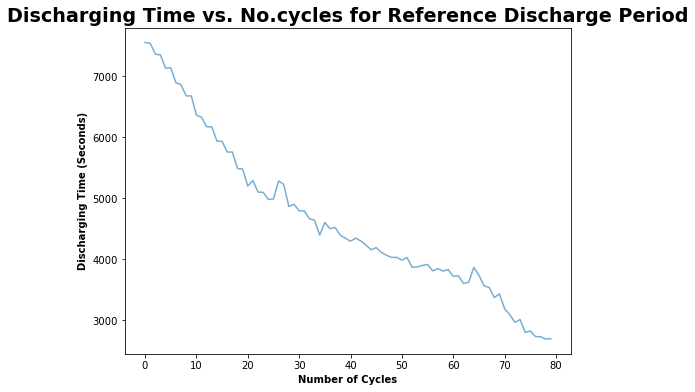

In [9]:
# ploting discharing time against number of cycles

duration = df_RDC['duration'].copy()
duration = [i for i in duration if i != 1199]

plt.figure(figsize=(8, 6)) 

plt.plot(duration, alpha
         = 0.6)
#plt.hlines(np.arange(100,601,100),0,184,colors='black', alpha = 0.3, linestyles='dashed',)

plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Discharging Time (Seconds)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Discharging Time vs. No.cycles for Reference Discharge Period',weight='bold')
plt.show()



####plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(15))


## Internal Resistence 

In [10]:
# internal resistence

df_RDC['internal_resistence'] = pd.Series() 
for i in range(0,80):
    df_RDC['internal_resistence'][i] = (df_RDC['voltage'][0][0] - df_RDC['voltage'][i][0] )/df_RDC['current_avg'][i]
  



<ipython-input-10-731e4ef3c003>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_RDC['internal_resistence'] = pd.Series()
<ipython-input-10-731e4ef3c003>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RDC['internal_resistence'][i] = (df_RDC['voltage'][0][0] - df_RDC['voltage'][i][0] )/df_RDC['current_avg'][i]


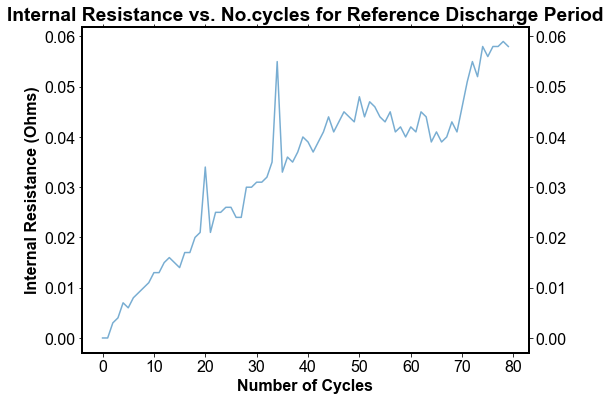

In [11]:
# plot internal resistance against cycles 
r = df_RDC['internal_resistence']

plt.figure(figsize=(8, 6)) 

plt.plot(r.index,r,alpha = 0.6)
plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Internal Resistance (Ohms)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Internal Resistance vs. No.cycles for Reference Discharge Period',weight='bold')
plt.show()



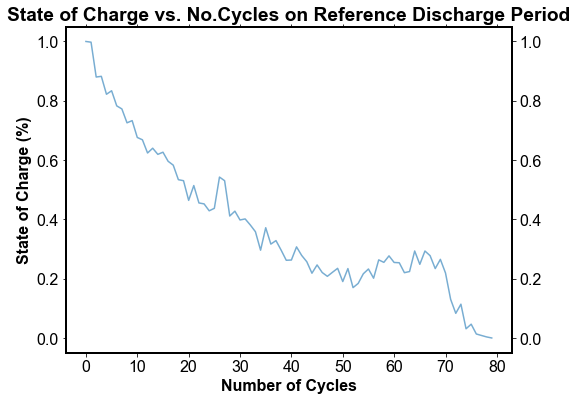

In [12]:
# state of charge voltage-based on load period

# state of charge voltage based
df_RDC['soc'] = (df_RDC['voltage_avg'] - min(df_RDC['voltage_avg']))/(max(df_RDC['voltage_avg']) - min(df_RDC['voltage_avg']))
soc = df_RDC['soc']
plt.figure(figsize=(8, 6)) 

plt.plot( soc, alpha = 0.6)
plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('State of Charge (%)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('State of Charge vs. No.Cycles on Reference Discharge Period',weight='bold')
plt.show()

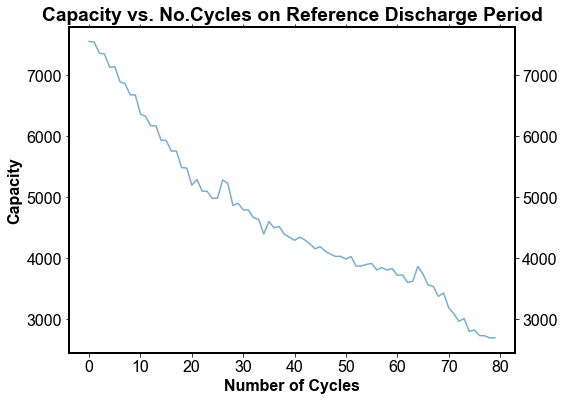

In [13]:
# capacity on reference discharge


df_RDC['capacity'] = (df_RDC['current_avg'] *  df_RDC['duration'] )
capacity = df_RDC['capacity']
plt.figure(figsize=(8, 6)) 

plt.plot( capacity, alpha = 0.6)


plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Capacity',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Capacity vs. No.Cycles on Reference Discharge Period',weight='bold')
plt.show()

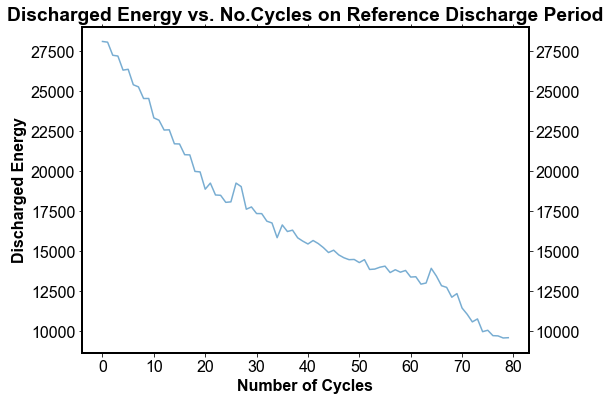

In [14]:
# discharge energy 
discharge_energy = list()
for i in range(len(df_RDC)):
    q =  (df_RDC['current_avg'][i] * df_RDC['duration'][i] * df_RDC['voltage_avg'][i])
    discharge_energy.append(q)
    
plt.figure(figsize=(8, 6)) 

plt.plot( discharge_energy, alpha = 0.6)

plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Discharged Energy',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Discharged Energy vs. No.Cycles on Reference Discharge Period',weight='bold')
plt.show()


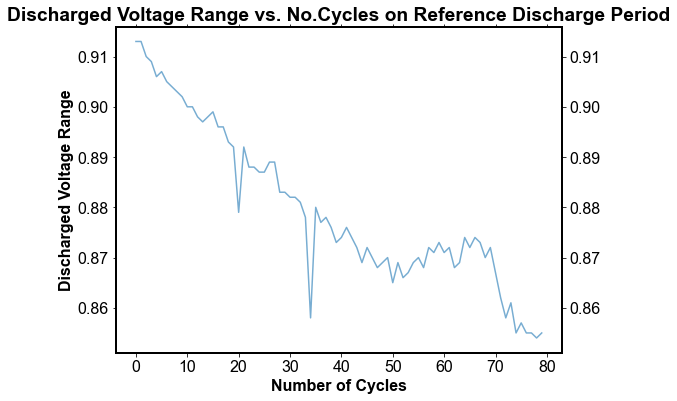

In [15]:

# discharge voltage range
discharge_range = list()
for i in range(0,80):
    v_r =  (max(df_RDC['voltage'][i]) - min(df_RDC['voltage'][i]))
    discharge_range.append(v_r)
    
plt.figure(figsize=(8, 6)) 

plt.plot( discharge_range, alpha = 0.6)

plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Discharged Voltage Range',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Discharged Voltage Range vs. No.Cycles on Reference Discharge Period',weight='bold')
plt.show()

# Define Failure Threshold

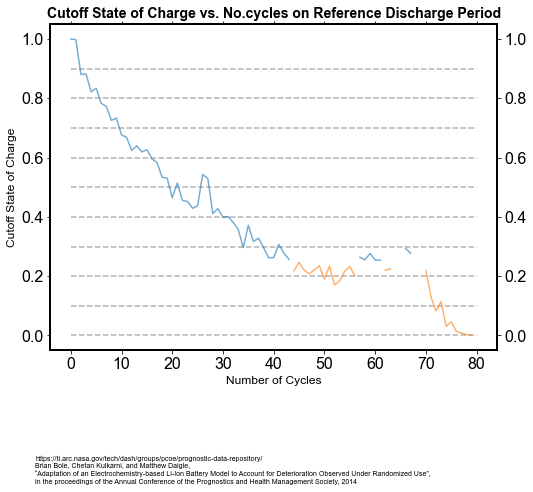

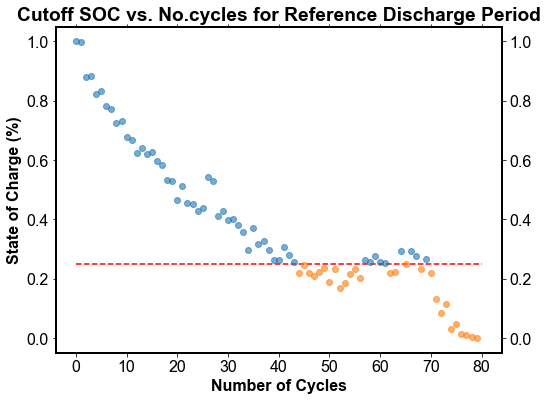

In [17]:
# define failure threshold


cutoff = 0.25 * soc[0]

unhealthy = np.ma.masked_where(soc > cutoff, soc)
healthy = np.ma.masked_where(soc <= cutoff, soc)

# plot soc against cycles 
plt.figure(figsize=(8, 6)) 

plt.plot(soc.index,healthy,soc.index,unhealthy, alpha = 0.6)
plt.ylabel('Cutoff State of Charge',fontsize = 12)
plt.xlabel('Number of Cycles',fontsize = 12)
plt.title('Cutoff State of Charge vs. No.cycles on Reference Discharge Period', c = 'black',fontsize = 14,weight='bold')
plt.hlines(np.arange(0.0,1,0.1),0,80,colors='black', alpha = 0.3, linestyles='dashed',)

plt.text(-7,-0.5, 'https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/\nBrian Bole, Chetan Kulkarni, and Matthew Daigle, \n“Adaptation of an Electrochemistry-based Li-Ion Battery Model to Account for Deterioration Observed Under Randomized Use”, \nin the proceedings of the Annual Conference of the Prognostics and Health Management Society, 2014',fontsize=7)   
plt.show()


# scatter plot

plt.figure(figsize=(8, 6)) 

plt.plot(soc.index,healthy,'o', soc.index,unhealthy,'o', alpha = 0.6)
plt.hlines(0.25,0,80,colors='red', linestyles='dashed',)

plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('State of Charge (%)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Cutoff SOC vs. No.cycles for Reference Discharge Period',weight='bold')
plt.show()


In [18]:
# find the cutoff cycle, the nearest cycle of the cutoff soc
cutoff_cycle = (np.abs(soc-cutoff)).argmin()
print('cutoff cycle is No.', cutoff_cycle)

# plot failure based on cutoff cycle



cutoff cycle is No. 65


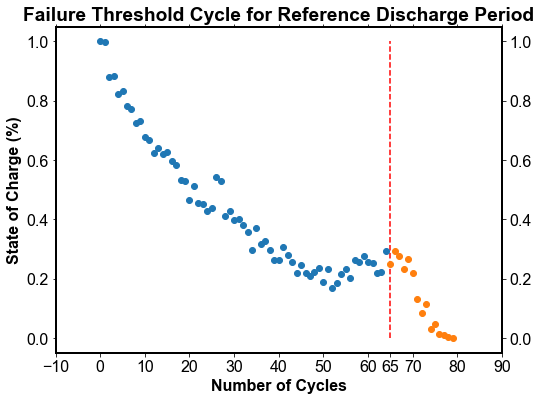

In [19]:
# plot failure based on cutoff cycle


plt.figure(figsize=(8, 6))
plt.plot(soc[0:65].index,soc[0:65],'o',soc[65:80].index,soc[65:80],'o')

plt.vlines(65,0,1, colors='red',linestyles='dashed')
plt.xticks(list(plt.xticks()[0]) + [65])


plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('State of Charge (%)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Failure Threshold Cycle for Reference Discharge Period',weight='bold')
plt.show()

# Cycle Estimation

## Prepare Estimation Dataframe

In [23]:
# State of Health dataframe on reference discharge period
# soh
# soc
# discharge_energy
c = list()
v_ocv = list()
v_bat = list()
cycle = np.arange(1,81)
d = list()
t = list()
for i in range(0,80):
    c.append(df_RDC['current_avg'][i])
    v_ocv.append(df_RDC['voltage_avg'][0])
    v_bat.append(df_RDC['voltage_avg'][i])
    d.append(df_RDC['duration'][i])
    t.append(df_RDC['temperature_avg'][i])

features = ['current','voltage_ocv','voltage_bat','internal_resistance','duration','temperature','soc','discharge_energy','discharge_range','capacity']
soh_rdc = pd.DataFrame([c,v_ocv,v_bat,r,d,t,soc,discharge_energy,discharge_range,capacity,cycle])
soh_rdc = np.transpose(soh_rdc)
soh_rdc.columns = ['current','voltage_ocv','voltage_bat','internal_resistance','duration','temperature','soc','discharge_energy','discharge_range','capacity','cycle']

np.random.seed(10)
threshold = np.random.rand(len(soh_rdc)) < 0.8
train = soh_rdc[threshold]
test = soh_rdc[~threshold]

X = train[features].astype(float)
Y = train['cycle'].astype(float)

X_test = test[features].astype(float)
Y_test = test['cycle'].astype(float) 


In [24]:
# select features
def minAIC_OLS(X,Y):
    variables = X.columns
    model = sm.OLS(Y,X[variables]).fit()
    while True:
        print(f'old model AIC：{model.aic}')
        maxp = np.max(model.pvalues)
        newvariables = variables[model.pvalues < maxp]
        removed = variables[model.pvalues == maxp].values
        print(f'consider a model with these variables removed:{removed}')
        newmodel = sm.OLS(Y,X[newvariables]).fit()
        print(f'new model AIC :{newmodel.aic}')
        if newmodel.aic < model.aic:
            model = newmodel
            variables = newvariables
        else:
            break
    return model, variables

In [25]:
model_new, features_new = minAIC_OLS(X,Y)
model_new.summary()
print(features_new)

old model AIC：350.96697692703765
consider a model with these variables removed:['soc']
new model AIC :350.966976927344
Index(['current', 'voltage_ocv', 'voltage_bat', 'internal_resistance',
       'duration', 'temperature', 'soc', 'discharge_energy', 'discharge_range',
       'capacity'],
      dtype='object')


## Random Forest

In [26]:
from statistics import mean
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score


# Iterate on Depth

In [35]:
depth = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
accuracy = list()
accuracy_modified = list()
mse = []
r2 = []
for d in depth:
    clf = DecisionTreeRegressor(random_state=0, criterion = "mse", splitter = "best", max_depth = d)
    model = clf.fit(X[features_new], Y) # Use the training data to build 
    y_test_pred = np.round(model.predict(X_test[features_new]))
    m = mean_squared_error(Y_test, y_test_pred)
    r = r2_score(Y_test, y_test_pred)

    mse.append(m)
    r2.append(r)
    print('depth:',d)
    print ("Test MSE on Reference Discharge Period ", m)
    print ("R2 on Reference Discharge Period ", r)
# cycle prediction accuracy
    y_pred = model.predict(soh_rdc[features_new].astype(float))
    y_pred = np.round(y_pred)

    soh_rdc['predict'] = y_pred

    correct = 0
    actual = list()
    pred = list()
    for i in range(len(soh_rdc)):
        if soh_rdc['predict'][i] == soh_rdc['cycle'][i]:
            correct += 1
        else:
            actual.append(soh_rdc['cycle'][i])
            pred.append(soh_rdc['predict'][i])
           
    acc = correct/80
    print('Accuracy for reference discharge cycle prediction before modified is:',acc)
    accuracy.append(acc)

# if prediction error is within one cycle, roughly considered as correct

    for i in range(len(soh_rdc)):
        if abs(soh_rdc['predict'][i] - soh_rdc['cycle'][i]) == 1:
            correct += 1
        
    acc_mod = correct/80
    print('Accuracy for cycle prediction after modified is:',acc_mod)
    accuracy_modified.append(acc_mod)
    print('-' * 50)



depth: 5
Test MSE on Reference Discharge Period  10.75
R2 on Reference Discharge Period  0.971642606159902
Accuracy for reference discharge cycle prediction before modified is: 0.4
Accuracy for cycle prediction after modified is: 0.7875
--------------------------------------------------
depth: 6
Test MSE on Reference Discharge Period  13.1875
R2 on Reference Discharge Period  0.9652127319752285
Accuracy for reference discharge cycle prediction before modified is: 0.6625
Accuracy for cycle prediction after modified is: 0.8625
--------------------------------------------------
depth: 7
Test MSE on Reference Discharge Period  10.9375
R2 on Reference Discharge Period  0.9711480004533886
Accuracy for reference discharge cycle prediction before modified is: 0.7625
Accuracy for cycle prediction after modified is: 0.9
--------------------------------------------------
depth: 8
Test MSE on Reference Discharge Period  10.9375
R2 on Reference Discharge Period  0.9711480004533886
Accuracy for refe

## From output parameters, the best model is random forest with depth = 9

In [41]:

# best depth is 9
clf = DecisionTreeRegressor(random_state=0, criterion = "mse", splitter = "best", max_depth = 9)
model = clf.fit(X[features_new], Y) # Use the training data to build 
y_test_pred = np.round(model.predict(X_test[features_new]))
m = mean_squared_error(Y_test, y_test_pred)
rscore = r2_score(Y_test, y_test_pred)


print('depth:',9)
print ("Test MSE on Reference Discharge Period ", m)
print ("R2 on Reference Discharge Period ", rscore)

y_pred = model.predict(soh_rdc[features_new].astype(float))
y_pred = np.round(y_pred)

soh_rdc['predict'] = y_pred

depth: 9
Test MSE on Reference Discharge Period  10.75
R2 on Reference Discharge Period  0.971642606159902


## Compare Estimation with Actual Condition

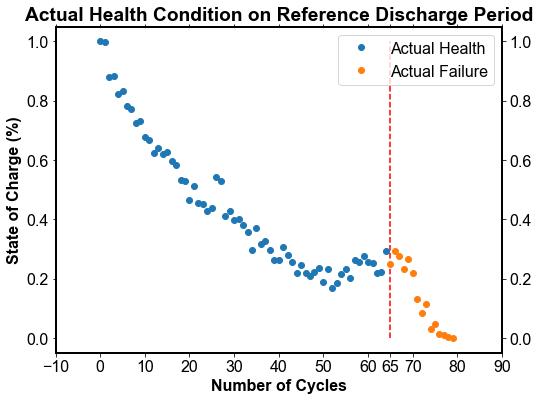

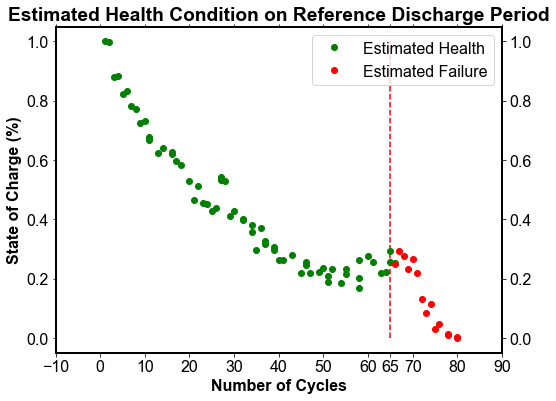

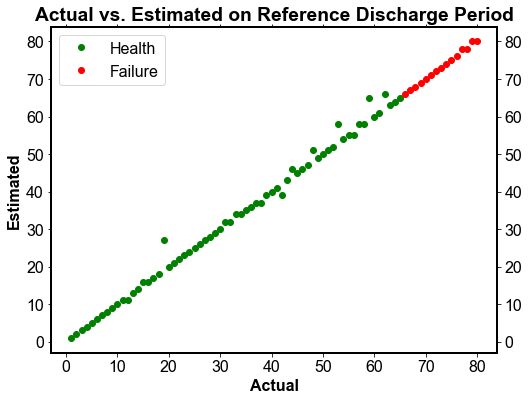

In [42]:
#actual data


plt.figure(figsize=(8, 6))
plt.plot(soc[0:65].index,soc[0:65],'o',label = 'Actual Health')
plt.plot(soc[65:80].index,soc[65:80],'o',label = 'Actual Failure')
plt.legend()

plt.vlines(65,0,1, colors='red',linestyles='dashed')

plt.xticks(list(plt.xticks()[0]) + [65])


plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('State of Charge (%)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Actual Health Condition on Reference Discharge Period',weight='bold')
plt.show()

# predicted data



plt.figure(figsize=(8, 6)) 

plt.plot(y_pred[0:65],soc[0:65],'o',label = 'Estimated Health', c = 'green')
plt.plot(y_pred[65:80],soc[65:80],'o',label = 'Estimated Failure', c = 'red')
plt.legend()

plt.vlines(65,0,1, colors='red',linestyles='dashed')
plt.xticks(list(plt.xticks()[0]) + [65])
plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('State of Charge (%)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Estimated Health Condition on Reference Discharge Period',weight='bold')
plt.show()

# compare actual and predicted


plt.figure(figsize=(8, 6)) 

plt.plot(soh_rdc['cycle'][0:65],y_pred[0:65],'o',label = 'Health', c = 'green')
plt.plot(soh_rdc['cycle'][65:80],y_pred[65:80],'o',label = 'Failure', c = 'red')
plt.legend()

plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Estimated',weight='bold')
plt.xlabel('Actual',weight='bold')
plt.title('Actual vs. Estimated on Reference Discharge Period',weight='bold')
plt.show()


## Cycle Prediciton Accuracy

In [43]:
# cycle prediciton accuracy
correct = 0
actual = list()
pred = list()
for i in range(len(soh_rdc)):
    if soh_rdc['predict'][i] == soh_rdc['cycle'][i]:
        correct += 1
    else:
        actual.append(soh_rdc['cycle'][i])
        pred.append(soh_rdc['predict'][i])
           
accuracy = correct/80
print('Accuracy for cycle prediction before modified is:',accuracy)

# if prediction error is within one cycle, roughly considered as correct

for i in range(len(soh_rdc)):
    if abs(soh_rdc['predict'][i] - soh_rdc['cycle'][i]) == 1:
        correct += 1
        
accuracy = correct/80
print('Accuracy for cycle prediction after modified is:',accuracy)


Accuracy for cycle prediction before modified is: 0.8
Accuracy for cycle prediction after modified is: 0.9125


## Application Model on Real-time Input

In [44]:
np.random.seed(20)

sample_data = soh_rdc.sample(n = 10)
sample_data = sample_data.reset_index(drop = True)

sample_x = sample_data[features_new].astype(float)
sample_y = sample_data['cycle']

sample_y_pred = np.round(model.predict(sample_x))

import sys
from termcolor import colored, cprint
  
for i in range(len(sample_y_pred)):
    print('For the follwing input data on reference discharge period:')
    print(sample_x.iloc[i].to_string())
    print(colored('The estimated current cycle is at'), colored('No.','green'), colored(int(sample_y_pred[i]),'green'))
    if sample_y_pred[i] < 65:
        print(colored('There are'), colored(65 - int(sample_y_pred[i]),'blue'), colored('cycles left to reach failure threshold'))
    else:
        print(colored('There are'), colored(int(sample_y_pred[i]) - 65,'red'), colored('cycles overused beyond the failure threshold'))

    print(colored('The actual current cycle is at'), colored('No.','green'), colored(int(int(sample_y[i])),'green'))
    if sample_y[i] < 65:
        print(colored('There are actual'), colored(65 - int(sample_y[i]) ,'blue'), colored('cycles left to reach failure threshold'))

    else:
        print(colored('There are actual'), colored(int(sample_y[i]) - 65,'red'), colored('cycles overused beyond the failure threshold'))

    if sample_y_pred[i] == sample_y[i]:
        print(colored('Correct Estimation','yellow'))
    else:
        print(colored('Error Estimation', 'yellow'))
    print('-----------------------------------------------------------------------------------------')


For the follwing input data on reference discharge period:
current                    0.999920
voltage_ocv                3.724370
voltage_bat                3.630840
internal_resistance        0.025002
duration                5096.000000
temperature               31.399608
soc                        0.452245
discharge_energy       18501.273681
discharge_range            0.888000
capacity                5095.591123
The estimated current cycle is at No. 24
There are 41 cycles left to reach failure threshold
The actual current cycle is at No. 24
There are actual 41 cycles left to reach failure threshold
Correct Estimation
-----------------------------------------------------------------------------------------
For the follwing input data on reference discharge period:
current                    0.999907
voltage_ocv                3.724370
voltage_bat                3.604222
internal_resistance        0.037003
duration                4396.000000
temperature               31.292950
soc    